In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# SQL Import Test

In [16]:
import sqlite3

con = sqlite3.connect("../db.sqlite3")

df = pd.read_sql_query('SELECT * FROM dashboard_coviddata', con)
df

id        Date Var   EC   FS   GP  KZN   LP   MP   NC   NW  Unknown  \
0    1295  2020-03-05   C  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0   
1    1296  2020-03-07   C  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0      0.0   
2    1297  2020-03-08   C  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0      0.0   
3    1298  2020-03-09   C  0.0  0.0  1.0  6.0  0.0  0.0  0.0  0.0      0.0   
4    1299  2020-03-11   C  0.0  0.0  5.0  7.0  0.0  0.0  0.0  0.0      0.0   
..    ...         ...  ..  ...  ...  ...  ...  ...  ...  ...  ...      ...   
991  2287  2020-11-22   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
992  2288  2020-11-23   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
993  2289  2020-11-24   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
994  2290  2020-11-25   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
995  2291  2020-11-26   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   

       Total Source   WC  
0          1         0.0  
1          2         0.0  
2          3         0.0  
3          7         0.0  
4         13         1.0  
..       ...    ...  ...  
991  5290966         NaN  
992  5305343         NaN  
993  5325631         NaN  
994  5355068         NaN  
995  5383078         NaN  

[996 rows x 15 columns]

# Download Data

## Download case data

In [17]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
date                                                                            
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311       0.0      0.0       5.0       7.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-24  20201124  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
2020-11-27  20201127  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-11-24  23003.0  34640.0  126571.0      0.0  772252   
2020-11-25  23044.0  34690.0  127646.0      0.0  775502   
2020-11-26  23095.0  34721.0  128703.0      0.0  778571   
2020-11-27  23118.0  34772.0  129726.0      0.0  781941   
2020-11-28  23156.0  34793.0  130782.0      0.0  785139   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[267 rows x 13 columns]

In [18]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-11-28 00:00:00'))

In [19]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28'],
              dtype='datetime64[ns]', length=269, freq='D')

In [20]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-24  20201124  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
2020-11-27  20201127  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-11-24  23003.0  34640.0  126571.0      0.0     772252   
2020-11-25  23044.0  34690.0  127646.0      0.0     775502   
2020-11-26  23095.0  34721.0  128703.0      0.0     778571   
2020-11-27  23118.0  34772.0  129726.0      0.0     781941   
2020-11-28  23156.0  34793.0  130782.0      0.0     785139   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 13 columns]

In [21]:
# Validate totals
states_cases_i = states_cases_i[state_filter]
states_cases_i['Total RSA'] = states_cases_i.sum(axis=1)
states_cases_i

/Users/schalk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



EC       FS        GP       KZN       LP       MP       NC  \
2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0      0.0   
2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0      0.0   
2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0      0.0   
...              ...      ...       ...       ...      ...      ...      ...   
2020-11-24  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0  23003.0   
2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0  23044.0   
2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0  23095.0   
2020-11-27  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0  23118.0   
2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0  23156.0   

                 NW        WC  Total RSA  
2020-03-05      0.0       0.0        1.0  
2020-03-06      0.0       0.0        1.0  
2020-03-07      0.0       0.0        2.0  
2020-03-08      0.0       0.0        3.0  
2020-03-09      0.0       0.0        7.0  
...             ...       ...        ...  
2020-11-24  34640.0  126571.0   772252.0  
2020-11-25  34690.0  127646.0   775502.0  
2020-11-26  34721.0  128703.0   778571.0  
2020-11-27  34772.0  129726.0   781941.0  
2020-11-28  34793.0  130782.0   785139.0  

[269 rows x 10 columns]

In [22]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date        EC       FS        GP       KZN       LP       MP  \
0   2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0   
1   2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0   
2   2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0   
3   2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0   
4   2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0   
..         ...       ...      ...       ...       ...      ...      ...   
264 2020-11-24  120052.0  58812.0  233343.0  126290.0  18420.0  31121.0   
265 2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
266 2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
267 2020-11-27  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
268 2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   

          NC       NW        WC  Total RSA  
0        0.0      0.0       0.0        1.0  
1        0.0      0.0       0.0        1.0  
2        0.0      0.0       0.0        2.0  
3        0.0      0.0       0.0        3.0  
4        0.0      0.0       0.0        7.0  
..       ...      ...       ...        ...  
264  23003.0  34640.0  126571.0   772252.0  
265  23044.0  34690.0  127646.0   775502.0  
266  23095.0  34721.0  128703.0   778571.0  
267  23118.0  34772.0  129726.0   781941.0  
268  23156.0  34793.0  130782.0   785139.0  

[269 rows x 11 columns]

## Download death data

In [23]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC    FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                     
2020-03-27  20200327     0     0     0     0    0    0    0    0     1   
2020-03-28  20200328     0     0     0     1    0    0    0    0     1   
2020-03-30  20200330     0     1     0     1    0    0    0    0     1   
2020-03-31  20200331     0     1     1     2    0    0    0    0     1   
2020-04-03  20200403     0     1     1     6    0    0    0    0     1   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...   ...   
2020-11-24  20201124  4424  1846  4989  3319  490  614  306  549  4546   
2020-11-25  20201125  4475  1870  4996  3321  494  614  306  549  4576   
2020-11-26  20201126  4508  1895  5001  3323  499  614  306  549  4594   
2020-11-27  20201127  4563  1914  5004  3328  499  614  306  549  4601   
2020-11-28  20201128  4589  1914  5005  3340  506  614  306  549  4616   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-11-24        0  21083  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25        0  21201  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26        0  21289  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27        0  21378  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28        0  21439  https://www.nicd.ac.za/latest-confirmed-cases-...  

[243 rows x 13 columns]

In [24]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0  306.0   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   
2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0  306.0   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-11-24  549.0  4546.0      0.0  21083.0   
2020-11-25  549.0  4576.0      0.0  21201.0   
2020-11-26  549.0  4594.0      0.0  21289.0   
2020-11-27  549.0  4601.0      0.0  21378.0   
2020-11-28  549.0  4616.0      0.0  21439.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 13 columns]

In [25]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0  306.0   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   
2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0  306.0   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-11-24  549.0  4546.0      0.0    21083.0   
2020-11-25  549.0  4576.0      0.0    21201.0   
2020-11-26  549.0  4594.0      0.0    21289.0   
2020-11-27  549.0  4601.0      0.0    21378.0   
2020-11-28  549.0  4616.0      0.0    21439.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 13 columns]

In [26]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC      FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...     ...     ...     ...    ...    ...   
264 2020-11-24  20201124.0  4424.0  1846.0  4989.0  3319.0  490.0  614.0   
265 2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0   
266 2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0   
267 2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0   
268 2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
264  306.0  549.0  4546.0      0.0    21083.0   
265  306.0  549.0  4576.0      0.0    21201.0   
266  306.0  549.0  4594.0      0.0    21289.0   
267  306.0  549.0  4601.0      0.0    21378.0   
268  306.0  549.0  4616.0      0.0    21439.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
264  https://www.nicd.ac.za/latest-confirmed-cases-...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  
267  https://www.nicd.ac.za/latest-confirmed-cases-...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 14 columns]

## Download recovery data

In [27]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD      EC     FS        GP     KZN     LP     MP     NC  \
date                                                                         
2020-04-17  20200417       9     71     479.0      96     18      9     10   
2020-04-18  20200418       9     71     479.0      96     18      9     10   
2020-04-19  20200419       9     71     479.0      96     18      9     10   
2020-04-20  20200420      15     74     545.0     151     21     14     13   
2020-04-21  20200421      15     74     545.0     151     21     14     13   
...              ...     ...    ...       ...     ...    ...    ...    ...   
2020-11-24  20201124  107116  49686  228111.0  117326  17637  30134  19428   
2020-11-25  20201125  107116  50174       NaN  117329  17637  30150  19449   
2020-11-26  20201126  109170  50532       NaN  117376  17662  30166  20061   
2020-11-27  20201127  109170  50629  228365.0  117405  17696  30234  20645   
2020-11-28  20201128  109170  50629  228365.0  117461  17696  30291  20653   

               NW      WC  UNKNOWN     total  \
date                                           
2020-04-17      6     205        0     903.0   
2020-04-18      6     205        0     903.0   
2020-04-19      6     205        0     903.0   
2020-04-20      6     216        0    1055.0   
2020-04-21      6     216        0    1055.0   
...           ...     ...      ...       ...   
2020-11-24  32861  114145        0  716444.0   
2020-11-25  33115  114548        0       NaN   
2020-11-26  33115  115017        0       NaN   
2020-11-27  33262  115470        0  722876.0   
2020-11-28  33315  115767        0  723347.0   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[220 rows x 13 columns]

In [28]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN       NaN      NaN       NaN       NaN      NaN   
...                ...       ...      ...       ...       ...      ...   
2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
2020-11-25  20201125.0  107116.0  50174.0       NaN  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0       NaN  117376.0  17662.0   
2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-11-24  30134.0  19428.0  32861.0  114145.0      0.0  716444.0   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0       NaN   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0       NaN   
2020-11-27  30234.0  20645.0  33262.0  115470.0      0.0  722876.0   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0  723347.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 13 columns]

In [29]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
...                ...       ...      ...       ...       ...      ...   
2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   
2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-11-24  30134.0  19428.0  32861.0  114145.0      0.0   716444.0   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   
2020-11-27  30234.0  20645.0  33262.0  115470.0      0.0   722876.0   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-24  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 13 columns]

In [30]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD        EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
..         ...         ...       ...      ...       ...       ...      ...   
264 2020-11-24  20201124.0  107116.0  49686.0  228111.0  117326.0  17637.0   
265 2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
266 2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   
267 2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
268 2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
264  30134.0  19428.0  32861.0  114145.0      0.0   716444.0   
265  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
266  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   
267  30234.0  20645.0  33262.0  115470.0      0.0   722876.0   
268  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
264  https://www.nicd.ac.za/latest-confirmed-cases-...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  
267  https://www.nicd.ac.za/latest-confirmed-cases-...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  

[269 rows x 14 columns]

## Download testing data
Only for country

In [31]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Name: cumulative_tests, Length: 272, dtype: float64

In [32]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
#print(states_tests_i.to_string())

In [33]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
2020-11-27    5383078.0
2020-11-28    5383078.0
Freq: D, Name: Total RSA, Length: 269, dtype: float64

In [34]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
264 2020-11-24  5325631.0
265 2020-11-25  5355068.0
266 2020-11-26  5383078.0
267 2020-11-27  5383078.0
268 2020-11-28  5383078.0

[269 rows x 2 columns]

# Analysis Per Province

In [35]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [36]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [37]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA        EC       FS        GP       KZN       LP  \
Date                                                                    
2020-03-05        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09        0.0       0.0      0.0       0.0       0.0      0.0   
...               ...       ...      ...       ...       ...      ...   
2020-11-24   737527.0  111540.0  51532.0  233100.0  120645.0  18127.0   
2020-11-25   737645.0  111591.0  52044.0  233107.0  120650.0  18131.0   
2020-11-26   737733.0  113678.0  52427.0  233112.0  120699.0  18161.0   
2020-11-27   744254.0  113733.0  52543.0  233369.0  120733.0  18195.0   
2020-11-28   744786.0  113759.0  52543.0  233370.0  120801.0  18202.0   

                 MP       NC       NW        WC  
Date                                             
2020-03-05      0.0      0.0      0.0       0.0  
2020-03-06      0.0      0.0      0.0       0.0  
2020-03-07      0.0      0.0      0.0       0.0  
2020-03-08      0.0      0.0      0.0       0.0  
2020-03-09      0.0      0.0      0.0       0.0  
...             ...      ...      ...       ...  
2020-11-24  30748.0  19734.0  33410.0  118691.0  
2020-11-25  30764.0  19755.0  33664.0  119124.0  
2020-11-26  30780.0  20367.0  33664.0  119611.0  
2020-11-27  30848.0  20951.0  33811.0  120071.0  
2020-11-28  30905.0  20959.0  33864.0  120383.0  

[269 rows x 10 columns]

In [38]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA        EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...       ...      ...       ...       ...      ...   
264 2020-11-24  -737527.0 -111540.0 -51532.0 -233100.0 -120645.0 -18127.0   
265 2020-11-25  -737645.0 -111591.0 -52044.0 -233107.0 -120650.0 -18131.0   
266 2020-11-26  -737733.0 -113678.0 -52427.0 -233112.0 -120699.0 -18161.0   
267 2020-11-27  -744254.0 -113733.0 -52543.0 -233369.0 -120733.0 -18195.0   
268 2020-11-28  -744786.0 -113759.0 -52543.0 -233370.0 -120801.0 -18202.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
264 -30748.0 -19734.0 -33410.0 -118691.0  
265 -30764.0 -19755.0 -33664.0 -119124.0  
266 -30780.0 -20367.0 -33664.0 -119611.0  
267 -30848.0 -20951.0 -33811.0 -120071.0  
268 -30905.0 -20959.0 -33864.0 -120383.0  

[269 rows x 11 columns]

In [39]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA       EC      FS      GP     KZN     LP     MP  \
0   2020-03-05        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
1   2020-03-06        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
2   2020-03-07        2.0      0.0     0.0     1.0     1.0    0.0    0.0   
3   2020-03-08        3.0      0.0     0.0     1.0     2.0    0.0    0.0   
4   2020-03-09        7.0      0.0     0.0     1.0     6.0    0.0    0.0   
..         ...        ...      ...     ...     ...     ...    ...    ...   
264 2020-11-24    34725.0   8512.0  7280.0   243.0  5645.0  293.0  373.0   
265 2020-11-25    37857.0   9738.0  6802.0   603.0  5985.0  308.0  399.0   
266 2020-11-26    40838.0   8909.0  6485.0   883.0  6167.0  316.0  435.0   
267 2020-11-27    37687.0  10334.0  6403.0   936.0  6486.0  325.0  420.0   
268 2020-11-28    40353.0  11721.0  6440.0  1202.0  6705.0  348.0  412.0   

         NC      NW       WC  
0       0.0     0.0      0.0  
1       0.0     0.0      0.0  
2       0.0     0.0      0.0  
3       0.0     0.0      0.0  
4       0.0     0.0      0.0  
..      ...     ...      ...  
264  3269.0  1230.0   7880.0  
265  3289.0  1026.0   8522.0  
266  2728.0  1057.0   9092.0  
267  2167.0   961.0   9655.0  
268  2197.0   929.0  10399.0  

[269 rows x 11 columns]

In [40]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [41]:
analysis_all = pd.concat([analysis_cases, analysis_recovery, analysis_active, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
2685 2020-11-24         WC  4546.0  Deaths
2686 2020-11-25         WC  4576.0  Deaths
2687 2020-11-26         WC  4594.0  Deaths
2688 2020-11-27         WC  4601.0  Deaths
2689 2020-11-28         WC  4616.0  Deaths

[10760 rows x 4 columns]

In [42]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [43]:
template_h = '%{y}'

## Plot analysis for provinces

In [44]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [45]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [46]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [47]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [48]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
264 2020-11-24  Total RSA  5325631.0  Tests
265 2020-11-25  Total RSA  5355068.0  Tests
266 2020-11-26  Total RSA  5383078.0  Tests
267 2020-11-27  Total RSA  5383078.0  Tests
268 2020-11-28  Total RSA  5383078.0  Tests

[1345 rows x 4 columns]

In [49]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [50]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [51]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [52]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
268 2020-11-28  Total RSA   785139.0      Cases
268 2020-11-28  Total RSA   723347.0  Recovered
268 2020-11-28  Total RSA    40353.0     Active
268 2020-11-28  Total RSA    21439.0     Deaths
268 2020-11-28  Total RSA  5383078.0      Tests

In [53]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [54]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('785,139', 723347.0, 40353.0, 21439.0, 5383078.0)

## Plot analysis per province

In [55]:
max_states = max(analysis_states['Value']) * 1.05
max_states

246300.6

In [56]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [57]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [58]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
2675 2020-11-24         WC  149.0  Active
2676 2020-11-25         WC  642.0  Active
2677 2020-11-26         WC  570.0  Active
2678 2020-11-27         WC  563.0  Active
2679 2020-11-28         WC  744.0  Active

[2680 rows x 4 columns]

In [59]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA      EC    FS     GP    KZN    LP    MP    NC    NW  \
2020-03-06        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-07        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-08        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-09        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-10        3.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
...               ...     ...   ...    ...    ...   ...   ...   ...   ...   
2020-11-24     2677.0  1309.0  36.0  230.0  204.0  21.0  39.0  31.0  33.0   
2020-11-25     2861.0  1325.0  36.0  257.0  237.0  24.0  41.0  35.0  35.0   
2020-11-26     3030.0  1348.0  39.0  278.0  267.0  28.0  44.0  36.0  37.0   
2020-11-27     3160.0  1367.0  41.0  292.0  290.0  32.0  48.0  37.0  38.0   
2020-11-28     3230.0  1385.0  42.0  296.0  302.0  35.0  50.0  36.0  36.0   

                WC  
2020-03-06     0.0  
2020-03-07     0.0  
2020-03-08     0.0  
2020-03-09     0.0  
2020-03-10     0.0  
...            ...  
2020-11-24   774.0  
2020-11-25   870.0  
2020-11-26   952.0  
2020-11-27  1015.0  
2020-11-28  1048.0  

[268 rows x 10 columns]

In [60]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province   Value            Data
0    2020-03-06  Total RSA     1.0  Cases Smoothed
1    2020-03-07  Total RSA     1.0  Cases Smoothed
2    2020-03-08  Total RSA     2.0  Cases Smoothed
3    2020-03-09  Total RSA     2.0  Cases Smoothed
4    2020-03-10  Total RSA     3.0  Cases Smoothed
...         ...        ...     ...             ...
2675 2020-11-24         WC   774.0  Cases Smoothed
2676 2020-11-25         WC   870.0  Cases Smoothed
2677 2020-11-26         WC   952.0  Cases Smoothed
2678 2020-11-27         WC  1015.0  Cases Smoothed
2679 2020-11-28         WC  1048.0  Cases Smoothed

[2680 rows x 4 columns]

In [61]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [62]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
263 2020-11-24  Total RSA  115.0  Deaths
264 2020-11-25  Total RSA  118.0  Deaths
265 2020-11-26  Total RSA   88.0  Deaths
266 2020-11-27  Total RSA   89.0  Deaths
267 2020-11-28  Total RSA   61.0  Deaths

[1340 rows x 4 columns]

In [63]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-11-24    20288.0
2020-11-25    29437.0
2020-11-26    28010.0
2020-11-27        0.0
2020-11-28        0.0
Freq: D, Name: Total RSA, Length: 268, dtype: float64

In [64]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
263 2020-11-24  Total RSA  20288.0  Tests
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests
266 2020-11-27  Total RSA      0.0  Tests
267 2020-11-28  Total RSA      0.0  Tests

[268 rows x 4 columns]

In [65]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
263 2020-11-24  Total RSA  20288.0  Tests
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests
266 2020-11-27  Total RSA      0.0  Tests
267 2020-11-28  Total RSA      0.0  Tests

[1608 rows x 4 columns]

## Plot daily change for South Africa

In [66]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [67]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [68]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [69]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [70]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [71]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
220 2020-11-17                NaN                  NaN              NaN   
221 2020-11-18                NaN                  NaN              NaN   
222 2020-11-19                NaN                  NaN              NaN   
223 2020-11-20                NaN                  NaN              NaN   
224 2020-11-21                NaN                  NaN              NaN   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases  Total  
220             NaN               NaN                    NaN    0.0  
221             NaN               NaN                    NaN    0.0  
222             NaN               NaN                    NaN    0.0  
223             NaN               NaN                    NaN    0.0  
224             NaN               NaN                    NaN    0.0

# Rt Model 1

## Data Import

In [72]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-23  1.05     0.00    0.00
          2020-11-24  1.25     0.00    0.00
          2020-11-25  1.38     0.00    0.00
          2020-11-26  1.40     0.00    0.00
          2020-11-27  1.34     0.00    0.00

[1881 rows x 3 columns]

In [73]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.35    0.79
1            EC 2020-04-12  3.35     5.13    1.25
2            EC 2020-04-13  3.12     4.54    1.56
3            EC 2020-04-14  2.72     3.88    1.41
4            EC 2020-04-15  2.27     3.29    1.12
...         ...        ...   ...      ...     ...
1876  Total RSA 2020-11-23  1.05     0.00    0.00
1877  Total RSA 2020-11-24  1.25     0.00    0.00
1878  Total RSA 2020-11-25  1.38     0.00    0.00
1879  Total RSA 2020-11-26  1.40     0.00    0.00
1880  Total RSA 2020-11-27  1.34     0.00    0.00

[1881 rows x 5 columns]

## Setup Rt

In [74]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
1627  Total RSA 2020-03-19  2.11      0.0     0.0
1628  Total RSA 2020-03-20  2.50      0.0     0.0
1629  Total RSA 2020-03-21  2.75      0.0     0.0
1630  Total RSA 2020-03-22  2.87      0.0     0.0
1631  Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1876  Total RSA 2020-11-23  1.05      0.0     0.0
1877  Total RSA 2020-11-24  1.25      0.0     0.0
1878  Total RSA 2020-11-25  1.38      0.0     0.0
1879  Total RSA 2020-11-26  1.40      0.0     0.0
1880  Total RSA 2020-11-27  1.34      0.0     0.0

[254 rows x 5 columns]

In [75]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [76]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('27 November 2020', 1.34)

## Latest Rt summary

In [77]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         1.07
FS         0.82
GP         1.49
LP         1.11
MP         0.97
NC         0.96
NW         1.03
Total RSA  1.34
WC         1.55

In [78]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [79]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [80]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [81]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0          EC 2020-04-11  3.84     6.35    0.79
1          EC 2020-04-12  3.35     5.13    1.25
2          EC 2020-04-13  3.12     4.54    1.56
3          EC 2020-04-14  2.72     3.88    1.41
4          EC 2020-04-15  2.27     3.29    1.12
...       ...        ...   ...      ...     ...
1622       WC 2020-11-23  1.43     1.73    1.09
1623       WC 2020-11-24  1.64     1.94    1.32
1624       WC 2020-11-25  1.68     1.95    1.35
1625       WC 2020-11-26  1.64     1.90    1.32
1626       WC 2020-11-27  1.55     1.81    1.25

[1627 rows x 5 columns]

In [82]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [83]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [84]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [85]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [86]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  2.052    2.340   1.762     143.316             0.000
1   2020-02-27  2.046    2.303   1.758       2.128             0.000
2   2020-02-28  2.045    2.262   1.724      30.181             0.000
3   2020-02-29  2.040    2.264   1.777      57.544             0.000
4   2020-03-01  2.032    2.310   1.834      64.318             0.000
..         ...    ...      ...     ...         ...               ...
272 2020-11-24  1.110    1.285   0.902    4041.580          3278.714
273 2020-11-25  1.107    1.275   0.870    4147.932          3350.396
274 2020-11-26  1.104    1.327   0.899    4261.226          3424.387
275 2020-11-27  1.102    1.315   0.886    4382.269          3500.908
276 2020-11-28  1.100    1.326   0.890    4511.716          3580.173

[277 rows x 6 columns]

In [87]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [88]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

1.1

In [89]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-11-28 00:00:00'), '28 November 2020')

In [90]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [91]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [92]:
Pc = 1-(1/rt2)
Pc * 100

9.090909090909093

In [93]:
immune = country_pop * Pc
immune

5343183.636363639

## Rt trends model

In [94]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date     Cases
0   2020-03-05       1.0
1   2020-03-06       1.0
2   2020-03-07       2.0
3   2020-03-08       3.0
4   2020-03-09       7.0
..         ...       ...
264 2020-11-24  772252.0
265 2020-11-25  775502.0
266 2020-11-26  778571.0
267 2020-11-27  781941.0
268 2020-11-28  785139.0

[269 rows x 2 columns]

In [95]:
from datetime import timedelta, date

In [96]:
f = 60

In [97]:
f2 = 30

In [98]:
diff = cases_df['Cases'].diff()

In [99]:
d = diff.values[-1]
d

3198.0

In [100]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3259999999999998,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.89,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [101]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2021-01-23  785494.333333  0.1
0  2021-01-24  785494.333333  0.1
0  2021-01-25  785494.333333  0.1
0  2021-01-26  785494.333333  0.1
0  2021-01-27  785494.333333  0.1

[7896 rows x 3 columns]

In [102]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.326
1  2020-03-06       1.000000  1.326
2  2020-03-07       2.000000  1.326
3  2020-03-08       3.000000  1.326
4  2020-03-09       7.000000  1.326
..        ...            ...    ...
0  2021-01-23  810975.820557  0.890
0  2021-01-24  810979.990296  0.890
0  2021-01-25  810983.701364  0.890
0  2021-01-26  810987.004214  0.890
0  2021-01-27  810989.943750  0.890

[987 rows x 3 columns]

In [103]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

810989

In [104]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.4%'

In [105]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [106]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [107]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [108]:
increasing_forecast = future_projections.query(f"R > 1")

In [109]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [110]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [111]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [112]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [113]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [114]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-23  1.05     0.00    0.00
          2020-11-24  1.25     0.00    0.00
          2020-11-25  1.38     0.00    0.00
          2020-11-26  1.40     0.00    0.00
          2020-11-27  1.34     0.00    0.00

[1881 rows x 3 columns]

In [115]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [116]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

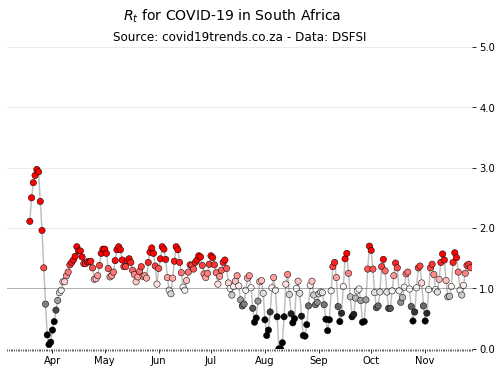

In [117]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [118]:
states_rt_i = states_all_rt_i.loc[state_filter]

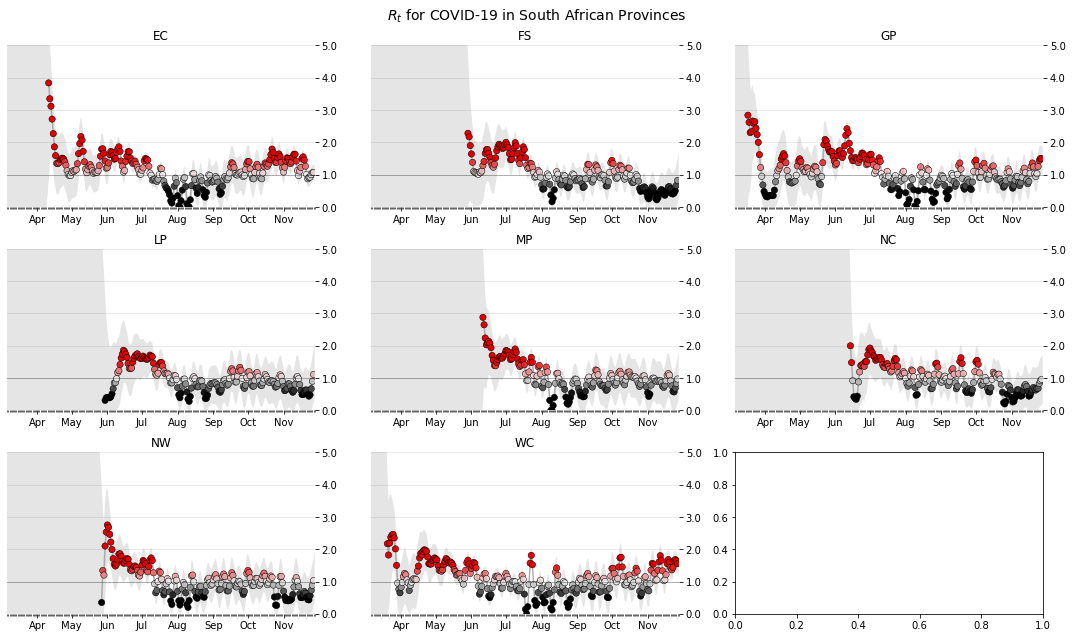

In [119]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [120]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [121]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         1.07     1.31    0.81
FS         0.82     1.49    0.10
GP         1.49     1.88    1.03
LP         1.11     1.87    0.22
MP         0.97     1.63    0.20
NC         0.96     1.67    0.17
NW         1.03     1.73    0.23
Total RSA  1.34     0.00    0.00
WC         1.55     1.81    1.25

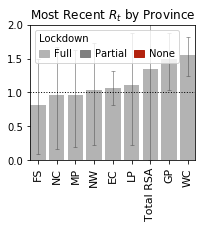

In [122]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

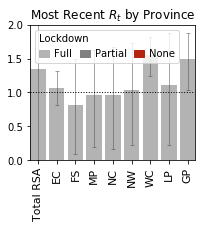

In [123]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

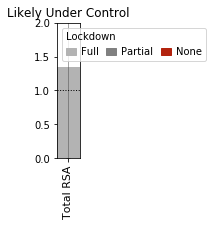

In [124]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

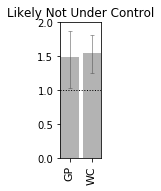

In [125]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()